# Data Source: Bugzilla

In [1]:
import pdb
import bugzilla
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
# tqdm extensions for pandas functions
tqdm.pandas()

## Get All Linked and Associated Bugs

In [3]:
# get the red hat dashboard names
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-informing?id=dashboard-group-bar"
)
html = BeautifulSoup(response.content)
testgrid_script = html.findAll("script")[3]
testgrid_script = testgrid_script.text.split()[5].split(",")
dashboard_names = [x.split(":")[1] for x in testgrid_script if "name" in x]
dashboard_names

['"redhat-assisted-installer"',
 '"redhat-openshift-informing"',
 '"redhat-openshift-ocp-release-4.1-blocking"',
 '"redhat-openshift-ocp-release-4.1-informing"',
 '"redhat-openshift-ocp-release-4.2-blocking"',
 '"redhat-openshift-ocp-release-4.2-informing"',
 '"redhat-openshift-ocp-release-4.3-blocking"',
 '"redhat-openshift-ocp-release-4.3-broken"',
 '"redhat-openshift-ocp-release-4.3-informing"',
 '"redhat-openshift-ocp-release-4.4-blocking"',
 '"redhat-openshift-ocp-release-4.4-broken"',
 '"redhat-openshift-ocp-release-4.4-informing"',
 '"redhat-openshift-ocp-release-4.5-blocking"',
 '"redhat-openshift-ocp-release-4.5-broken"',
 '"redhat-openshift-ocp-release-4.5-informing"',
 '"redhat-openshift-ocp-release-4.6-blocking"',
 '"redhat-openshift-ocp-release-4.6-broken"',
 '"redhat-openshift-ocp-release-4.6-informing"',
 '"redhat-openshift-ocp-release-4.7-blocking"',
 '"redhat-openshift-ocp-release-4.7-broken"',
 '"redhat-openshift-ocp-release-4.7-informing"',
 '"redhat-openshift-ocp-re

**NOTE** Since other notebooks also look at only one dashboard and job, we'll do the same. at the end we'll save the dataset for further analysis.

In [4]:
# bugs linked at timestamps up to this amount of time before today will be returned
max_age = '336h'

# ci details search url
url = 'https://search.ci.openshift.org/'

dashboard = '"redhat-openshift-ocp-release-4.2-informing"'

In [5]:
# get all linked bugs
associated_bugs = list()
all_linked_bugs = set()

# get all jobs in this dashboard
response = requests.get(f"https://testgrid.k8s.io/{dashboard}/summary")
job_names = response.json().keys()

for job in tqdm(job_names):
    # get all tests in this job
    response = requests.get(f"https://testgrid.k8s.io/{dashboard}/table?&show-stale-tests=&tab={job}")

    # params to send to openshift ci search for tests under this job
    args = {
        'type': 'bug+junit',
        'context': '-1',
        'name': job,
        'maxAge': max_age,
        # DO NOT REMOVE THESE KEYS. THIS HACK PREVENTS REQUESTS FROM TIMING OUT.
        # read more here - https://stackoverflow.com/a/63377265/9743348
        'ajax': 'true',
        'mobile': 'false',
    }

    for test in response.json().get('tests', []):
        testname = test['name'].split('.', maxsplit=1)[-1]

        # use test name as the search phrase
        args['search'] = testname.replace('[', '\[').replace(']', '\]')

        # search for linked and associated bugs for this test
        response = requests.post(url, data=args)
        soup = BeautifulSoup(response.content)

        # the "em" objects in soup have information that can tell us
        # whether or not this test had a linked bug for the given job name
        em_objects = soup.find_all('em')
        pct_affected = 0
        for em in em_objects:
            if 'Found' in em.text:
                pct_affected = float(em.text.split()[2][:-1])
                break

        # init to empty for this test result / reset to empty from previous test result
        test_bugs = []

        # if percent jobs affected is 0 then the linked bugs correspond to another job
        if pct_affected > 0:
            result_rows = soup.find('table').find('tbody').find_all('tr')
            for row in result_rows:
                column_values = row.find_all('td')

                # if there is only 1 column then the result is a junit, not bug
                if len(column_values) > 1:
                    # check the second column to make sure it is a bug and not junit details result
                    if column_values[1].text == 'bug':
                        test_bugs.append(column_values[0].text[1:])
                        all_linked_bugs.add(column_values[0].text[1:])

        associated_bugs.append((dashboard, job, test, test_bugs))

100%|██████████| 31/31 [17:14<00:00, 33.37s/it] 


In [6]:
linked_and_associated_bugs = pd.DataFrame(associated_bugs, columns=['dashboard', 'job', 'test_name', 'bug_ids'])
linked_and_associated_bugs.head()

,dashboard,job,test_name,bug_ids
0,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,"{'name': 'Overall', 'original-name': 'Overall'...",[]
1,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,[]
2,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'Operator results.operator conditions...,[]
3,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,[]
4,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,[]


In [7]:
# todo: distribution of bugs across jobs

## Get Bugzilla Details

In [8]:
bzapi = bugzilla.Bugzilla("bugzilla.redhat.com")

In [9]:
samplebug = bzapi.getbug(1883345)
dir(samplebug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_aliases',
 '_rawdata',
 '_translate_dict',
 '_update_dict',
 'addcc',
 'addcomment',
 'alias',
 'assigned_to',
 'assigned_to_detail',
 'autorefresh',
 'blocks',
 'bugzilla',
 'cc',
 'cc_detail',
 'cf_clone_of',
 'cf_doc_type',
 'cf_environment',
 'cf_last_closed',
 'cf_release_notes',
 'cf_target_upstream_version',
 'classification',
 'close',
 'comments',
 'component',
 'components',
 'creation_time',
 'creator',
 'creator_detail',
 'deletecc',
 'depends_on',
 'description',
 'docs_contact',
 'external_bugs',
 'fixed_in',
 'flags',
 'get_attachment_ids',

In [10]:
# lets peek at some of the available bug metadata
samplebug._rawdata

{'priority': 'low',
 'cf_last_closed': <DateTime '20201105T12:46:56' at 0x7fefe177e430>,
 'creator': 'Cesar Wong',
 'blocks': [1883348],
 'assigned_to_detail': {'real_name': 'Cesar Wong',
  'email': 'cewong',
  'name': 'cewong',
  'id': 368980},
 'last_change_time': <DateTime '20201105T12:47:17' at 0x7fefe177eca0>,
 'comments': [{'is_private': False,
   'count': 0,
   'creator': 'cewong',
   'time': <DateTime '20200928T20:47:20' at 0x7fefe177eb80>,
   'bug_id': 1883345,
   'tags': [],
   'text': '+++ This bug was initially created as a clone of Bug #1883343 +++\n\nRe-enabling selected tests now that associated bugs have been fixed and are in the Red Hat OpenShift on IBM Cloud v4.3 builds\n\n[Feature:Prometheus][Conformance] Prometheus when installed on the cluster should provide ingress metrics\n[Conformance][Area:Networking][Feature:Router] The HAProxy router should enable openshift-monitoring to pull metrics\n[k8s.io] [sig-node] Pods Extended [k8s.io] Pod Container Status should neve

In [11]:
samplebug.bugzilla

In [12]:
samplebug._aliases

[('summary', 'short_desc'),
 ('description', 'comment'),
 ('platform', 'rep_platform'),
 ('severity', 'bug_severity'),
 ('status', 'bug_status'),
 ('id', 'bug_id'),
 ('blocks', 'blockedby'),
 ('blocks', 'blocked'),
 ('depends_on', 'dependson'),
 ('creator', 'reporter'),
 ('url', 'bug_file_loc'),
 ('dupe_of', 'dupe_id'),
 ('dupe_of', 'dup_id'),
 ('comments', 'longdescs'),
 ('creation_time', 'opendate'),
 ('creation_time', 'creation_ts'),
 ('whiteboard', 'status_whiteboard'),
 ('last_change_time', 'delta_ts'),
 ('fixed_in', 'cf_fixed_in'),
 ('qa_whiteboard', 'cf_qa_whiteboard'),
 ('devel_whiteboard', 'cf_devel_whiteboard'),
 ('internal_whiteboard', 'cf_internal_whiteboard'),
 ('flags', 'flag_types')]

**NOTE** `_rawdata` seems redundant, the information is already captured in other fields. And `bugzilla` attribute is depracated / old representation.

In [13]:
list(vars(samplebug).keys()).remove('bugzilla')

In [14]:
# get all the available fields, except the depracated and duplicate ones
bug_details_to_get = list(vars(samplebug).keys())
bug_details_to_get.remove('_rawdata')
bug_details_to_get.remove('bugzilla')
bug_details_to_get.remove('_aliases')

# these two keys are msissing for a lot of bugs
bug_details_to_get.remove('qa_contact_detail')
bug_details_to_get.remove('cf_last_closed')
bug_details_to_get.remove('cf_clone_of')

bug_details_to_get

['autorefresh',
 'priority',
 'creator',
 'blocks',
 'assigned_to_detail',
 'last_change_time',
 'comments',
 'is_cc_accessible',
 'keywords',
 'creator_detail',
 'cc',
 'see_also',
 'groups',
 'assigned_to',
 'url',
 'qa_contact',
 'creation_time',
 'whiteboard',
 'id',
 'depends_on',
 'cf_target_upstream_version',
 'docs_contact',
 'description',
 'resolution',
 'classification',
 'cf_doc_type',
 'alias',
 'op_sys',
 'target_release',
 'status',
 'cc_detail',
 'external_bugs',
 'summary',
 'is_open',
 'platform',
 'severity',
 'cf_environment',
 'flags',
 'version',
 'tags',
 'component',
 'sub_components',
 'is_creator_accessible',
 'cf_release_notes',
 'product',
 'target_milestone',
 'is_confirmed',
 'components',
 'versions',
 'sub_component',
 'fixed_in',
 'weburl']

In [15]:
# create a df containing details of all linked and associated bugs
bugs_df = pd.DataFrame(columns=['bug_id'] + bug_details_to_get, index=range(len(all_linked_bugs)))
bugs_df = bugs_df.assign(bug_id=all_linked_bugs)
bugs_df.head()

,bug_id,autorefresh,priority,creator,blocks,assigned_to_detail,last_change_time,comments,is_cc_accessible,keywords,...,is_creator_accessible,cf_release_notes,product,target_milestone,is_confirmed,components,versions,sub_component,fixed_in,weburl
0,1934731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1882505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1809892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1861498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1948535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
def fill_bug_details(bug_row):
    global bzapi
    
    try:
        bug = bzapi.getbug(bug_row.bug_id)
    except Exception:
        return bug_row
    
    for detail in bug_row.index:
        try:
            bug_row[detail] = getattr(bug, detail)
        except AttributeError:
            print(detail)

    return bug_row

bugs_df.progress_apply(fill_bug_details, axis=1)
bugs_df

100%|██████████| 2772/2772 [30:35<00:00,  1.51it/s] 


,bug_id,autorefresh,priority,creator,blocks,assigned_to_detail,last_change_time,comments,is_cc_accessible,keywords,...,is_creator_accessible,cf_release_notes,product,target_milestone,is_confirmed,components,versions,sub_component,fixed_in,weburl
0,1934731,False,unspecified,Neil Girard,[],"{'real_name': 'Stefan Schimanski', 'email': 's...",20210304T09:47:33,"[{'is_private': False, 'count': 0, 'creator': ...",True,[],...,True,,OpenShift Container Platform,---,True,[kube-apiserver],[4.4],,,https://bugzilla.redhat.com/show_bug.cgi?id=19...
1,1882505,False,medium,Devan Goodwin,[],"{'real_name': 'Devan Goodwin', 'email': 'dgood...",20201027T16:45:46,"[{'is_private': False, 'count': 0, 'creator': ...",True,[],...,True,,OpenShift Container Platform,---,True,[Cloud Credential Operator],[4.6],,,https://bugzilla.redhat.com/show_bug.cgi?id=18...
2,1809892,False,medium,wewang,[],"{'real_name': 'Adam Kaplan', 'email': 'adam.ka...",20210225T15:08:23,"[{'is_private': False, 'count': 0, 'creator': ...",True,[],...,True,,OpenShift Container Platform,---,True,[openshift-controller-manager],[4.4],controller-manager,,https://bugzilla.redhat.com/show_bug.cgi?id=18...
3,1861498,False,medium,Naveen Malik,[],"{'real_name': 'Antonio Murdaca', 'email': 'amu...",20201117T22:20:41,"[{'is_private': False, 'count': 0, 'creator': ...",True,[ServiceDeliveryImpact],...,True,,OpenShift Container Platform,---,True,[Machine Config Operator],[4.4],,,https://bugzilla.redhat.com/show_bug.cgi?id=18...
4,1948535,False,unspecified,Qin Ping,[],"{'real_name': 'aos-storage-staff@redhat.com', ...",20210415T15:26:24,"[{'is_private': False, 'count': 0, 'creator': ...",True,[],...,True,,OpenShift Container Platform,---,True,[Storage],[4.8],Operators,,https://bugzilla.redhat.com/show_bug.cgi?id=19...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767,1857084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2768,1924917,False,high,Robert Heinzmann,[1928029],"{'real_name': 'Michał Dulko', 'email': 'mdulko...",20210223T12:17:59,"[{'is_private': False, 'count': 0, 'creator': ...",True,[],...,True,,OpenShift Container Platform,---,True,[Networking],[4.6],kuryr,,https://bugzilla.redhat.com/show_bug.cgi?id=19...
2769,1936006,False,unspecified,Tyler Lisowski,[],"{'real_name': 'Oleg Bulatov', 'email': 'obulat...",20210308T12:27:28,"[{'is_private': False, 'count': 0, 'creator': ...",True,[],...,True,,OpenShift Container Platform,---,True,[Image Registry],[4.6],,,https://bugzilla.redhat.com/show_bug.cgi?id=19...
2770,1928619,False,unspecified,Seunghwan Jung,[],"{'real_name': 'Micah Abbott', 'email': 'miabbo...",20210327T07:04:48,"[{'is_private': False, 'count': 0, 'creator': ...",True,[],...,True,,OpenShift Container Platform,---,True,[RHCOS],[4.6],,,https://bugzilla.redhat.com/show_bug.cgi?id=19...


In [17]:
for i in bugs_df.columns:
    print(i)

bug_id
autorefresh
priority
creator
blocks
assigned_to_detail
last_change_time
comments
is_cc_accessible
keywords
creator_detail
cc
see_also
groups
assigned_to
url
qa_contact
creation_time
whiteboard
id
depends_on
cf_target_upstream_version
docs_contact
description
resolution
classification
cf_doc_type
alias
op_sys
target_release
status
cc_detail
external_bugs
summary
is_open
platform
severity
cf_environment
flags
version
tags
component
sub_components
is_creator_accessible
cf_release_notes
product
target_milestone
is_confirmed
components
versions
sub_component
fixed_in
weburl


## Bug fields

### Whiteboard
A free-form text area for adding short notes and tags to a bug.

In [18]:
print("Length of unique values of whiteboard : ", len(bugs_df.whiteboard.unique()))
bugs_df.whiteboard.value_counts().to_frame().head()

Length of unique values of whiteboard :  59


,whiteboard
,2390
logging-exploration,44
LifecycleStale,33
LifecycleReset,28
logging-core,19


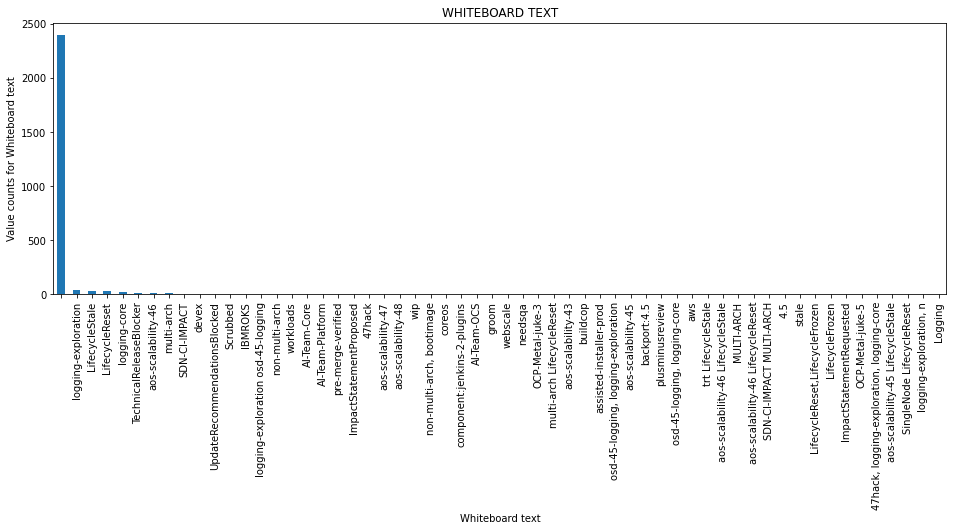

In [19]:
plt.figure(figsize=(16,5))
bugs_df.whiteboard.value_counts().plot.bar()
plt.xticks(rotation = 90)
plt.title("WHITEBOARD TEXT")
plt.xlabel("Whiteboard text")
plt.ylabel("Value counts for Whiteboard text")
plt.show()

From the above graph, we can conclude that even though we have 58 unique values for `whiteboard` , most of them are empty. 

### cf_target_upstream_version

In [20]:
bugs_df.cf_target_upstream_version.unique()

array(['', nan, '4.8.0'], dtype=object)

### docs_contact_value and qa_contact 
The people responsible for contacting and fixing the bug

In [21]:
bugs_df.docs_contact.value_counts()

                      2499
Vikram Goyal           104
Rolfe Dlugy-Hegwer       9
Harsh Mishra             4
Marc Muehlfeld           4
Avital Pinnick           4
Kathryn Alexander        3
Kevin Owen               2
Robert Krátký            2
Radek Vokál              2
Christopher Dawson       1
Ashleigh                 1
Rishu Mehra              1
Name: docs_contact, dtype: int64

In [22]:
bugs_df.qa_contact.value_counts()

Michael Nguyen    177
zhaozhanqi        139
Anurag saxena     100
Qin Ping           97
Jian Zhang         96
                 ... 
Neha Berry          1
Ben Eli             1
Maayan Hadasi       1
Oded                1
Cuiping HUO         1
Name: qa_contact, Length: 148, dtype: int64

Most of the tickets have no contacts assigned, but this could be useful so as to automatically identify the bug associated and assign the authorized person to the ticket.

### description 
This conatins descriptions for each bugzilla ticket.

In [23]:
bugs_df.description

0       Description of problem:\nopenshift-kube-apiser...
1       Description of problem:\n\nIN 4.6 the leader e...
2       Description of problem:\n3 Pods cannot be runn...
3       Description of problem:\nA node was deleted on...
4       Description of problem:\nSTEP: Destroying name...
                              ...                        
2767                                                  NaN
2768    Description of problem:\n\nWhen the fixed_ip o...
2769    Description of problem:\nWhen the node an imag...
2770    Description of problem:\n\nYou can not ping th...
2771    Description of problem:\nChanges done for the ...
Name: description, Length: 2772, dtype: object

This section contains information for all the values, and can be used for identifying more details about a given bug.

### resolution

In [24]:
print("Length of resolution: ", len(bugs_df.resolution.unique()))
display(bugs_df.resolution.value_counts().to_frame().head())

Length of resolution:  14


,resolution
ERRATA,1020
,718
DUPLICATE,260
NOTABUG,245
CURRENTRELEASE,101


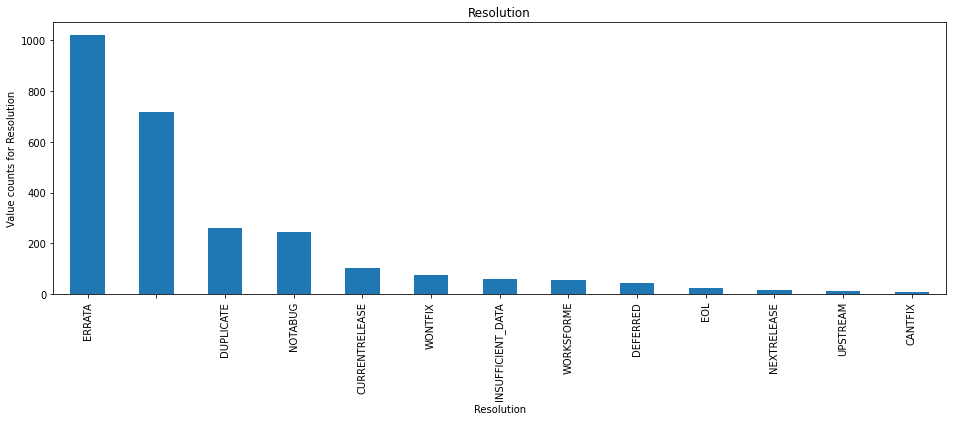

In [25]:
plt.figure(figsize=(16,5))
bugs_df.resolution.value_counts().plot.bar()
plt.xticks(rotation = 90)
plt.title("Resolution")
plt.xlabel("Resolution")
plt.ylabel("Value counts for Resolution")
plt.show()

From the above graph, we can infer that we have most values available for resolution, even though we have many values as empty, this looks like a promising parameter.

### classification : 

In [26]:
bugs_df.classification.unique()

array(['Red Hat', nan], dtype=object)

### cf_doc_type

In [27]:
print("",len(bugs_df.cf_doc_type.unique()))
display(bugs_df.cf_doc_type.value_counts().to_frame().head())

 8


,cf_doc_type
"If docs needed, set a value",2059
No Doc Update,339
Bug Fix,212
Enhancement,11
Release Note,8


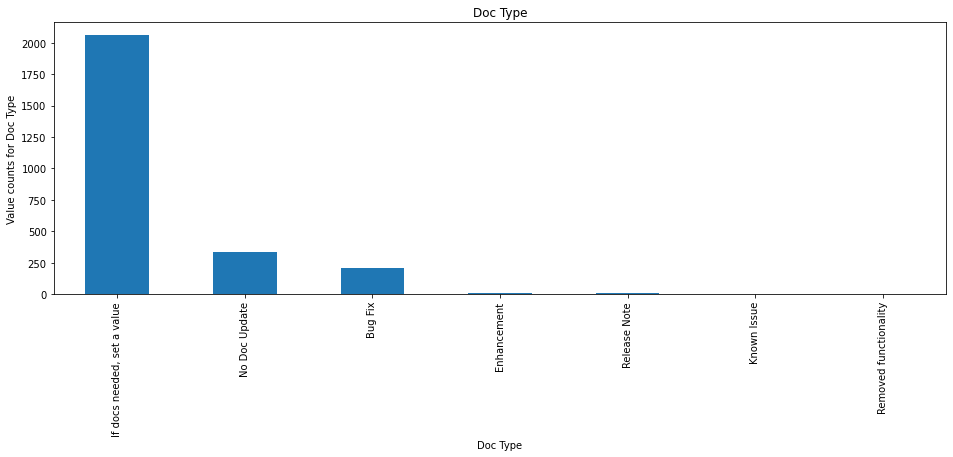

In [28]:
plt.figure(figsize=(16,5))
bugs_df.cf_doc_type.value_counts().plot.bar()
plt.xticks(rotation = 90)
plt.title("Doc Type")
plt.xlabel("Doc Type")
plt.ylabel("Value counts for Doc Type")
plt.show()

From the above graph, we see that most of the tickets have the value for `doc_type`. This could be used to classify the tickets according to the doc type.

### op_sys : Operating Systems

In [29]:
print("Various Operating Systems : ", len(bugs_df.op_sys.unique()))
display(bugs_df.op_sys.value_counts().to_frame().head())

Various Operating Systems :  6


,op_sys
Unspecified,2264
Linux,312
All,57
Mac OS,2
Windows,1


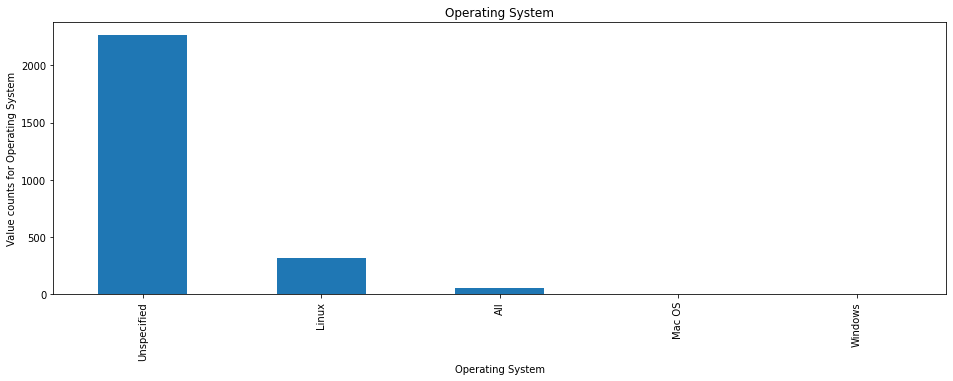

In [30]:
plt.figure(figsize=(16,5))
bugs_df.op_sys.value_counts().plot.bar()
plt.xticks(rotation = 90)
plt.title("Operating System")
plt.xlabel("Operating System")
plt.ylabel("Value counts for Operating System")
plt.show()

From the above graph, we can see that we have four OS(s) across the bugs.

### target_release

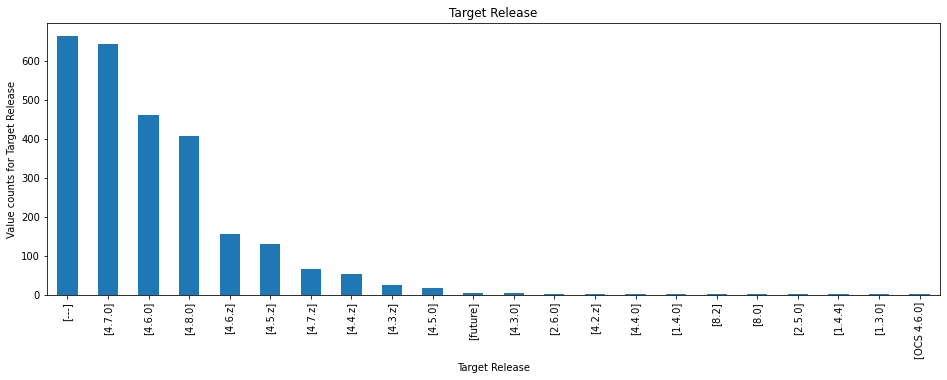

In [31]:
plt.figure(figsize=(16,5))
bugs_df.target_release.value_counts().plot.bar()
plt.xticks(rotation = 90)
plt.title("Target Release")
plt.xlabel("Target Release")
plt.ylabel("Value counts for Target Release")
plt.show()

From the above graph, we see the various target releases frequency. This value also is mostly not assigned but we still have many observations.

### status

In [32]:
print("Various Statuses : ", len(bugs_df.status.unique()))
display(bugs_df.status.value_counts().to_frame())

Various Statuses :  9


,status
CLOSED,1918
NEW,234
ASSIGNED,195
VERIFIED,172
POST,69
ON_QA,39
MODIFIED,8
RELEASE_PENDING,1


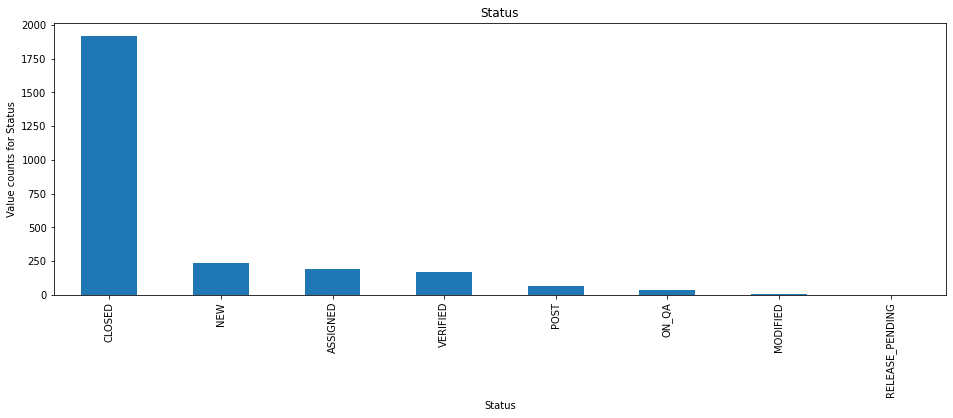

In [33]:
plt.figure(figsize=(16,5))
bugs_df.status.value_counts().plot.bar()
plt.xticks(rotation = 90)
plt.title("Status")
plt.xlabel("Status")
plt.ylabel("Value counts for Status")
plt.show()

The above graph, shows various status across tickets.

### cc_detail

In [34]:
display(bugs_df.cc_detail.value_counts().to_frame().head())

,cc_detail
"[{'real_name': 'aos-bugs@redhat.com', 'email': 'aos-bugs', 'name': 'aos-bugs', 'id': 385833}]",62
[],56
"[{'real_name': 'aos-bugs@redhat.com', 'email': 'aos-bugs', 'name': 'aos-bugs', 'id': 385833}, {'real_name': 'Joanne Okerman', 'email': 'jokerman', 'name': 'jokerman', 'id': 344626}]",33
"[{'real_name': 'aos-bugs@redhat.com', 'email': 'aos-bugs', 'name': 'aos-bugs', 'id': 385833}, {'real_name': 'Michal Fojtik', 'email': 'mfojtik', 'name': 'mfojtik', 'id': 290313}]",29
"[{'real_name': 'aos-bugs@redhat.com', 'email': 'aos-bugs', 'name': 'aos-bugs', 'id': 385833}, {'real_name': 'Jan Safranek', 'email': 'jsafrane', 'name': 'jsafrane', 'id': 211668}]",23


<Figure size 1152x360 with 0 Axes>

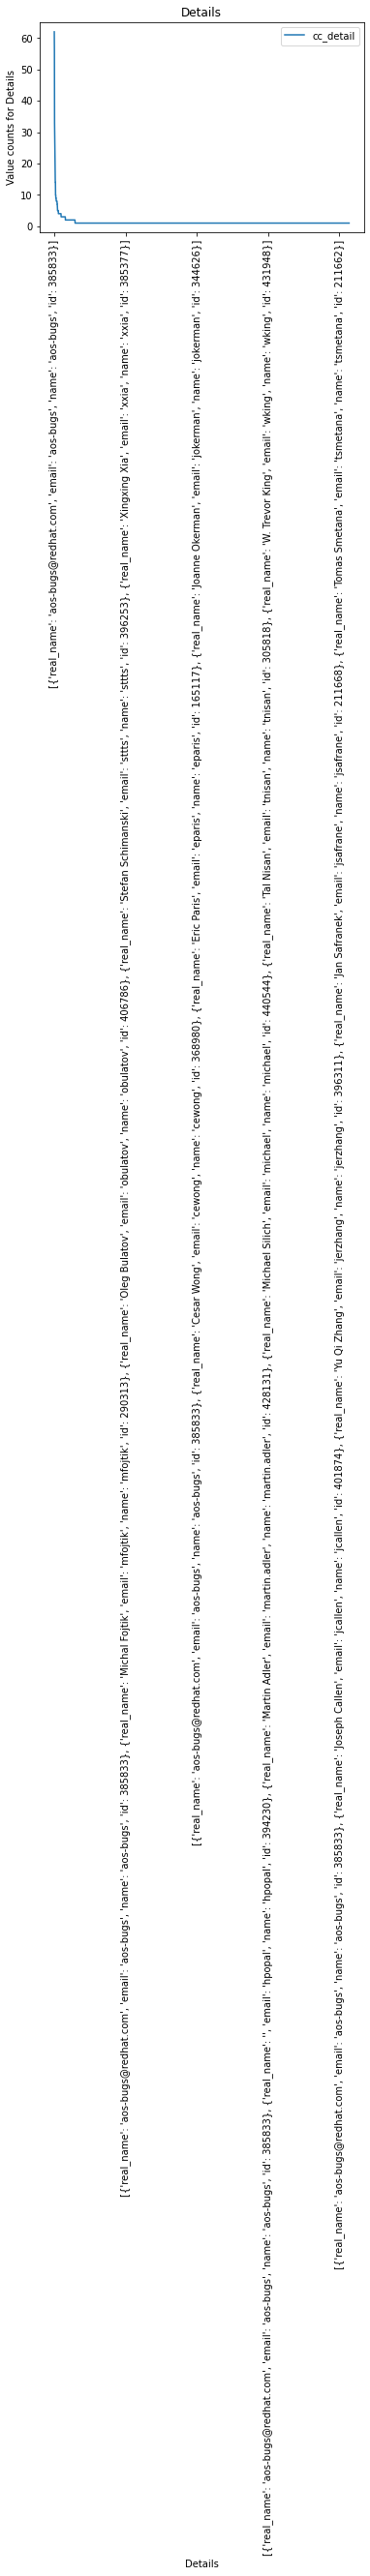

In [35]:
plt.figure(figsize=(16,5))
bugs_df.cc_detail.value_counts().to_frame().plot()
plt.xticks(rotation = 90)
plt.title("Details")
plt.xlabel("Details")
plt.ylabel("Value counts for Details")
plt.show()

### External Bugs

In [36]:
display(bugs_df.external_bugs.value_counts().to_frame().head())

,external_bugs
[],1210
"[{'ext_description': 'Bug 1908675: Re-Enable fsgroup policy test', 'ext_bz_id': 131, 'ext_priority': 'None', 'bug_id': 1908675, 'ext_bz_bug_id': 'openshift/origin/pull/25775', 'id': 1703177, 'ext_status': 'closed', 'type': {'must_send': False, 'can_send': False, 'description': 'Github', 'can_get': True, 'url': 'https://github.com/', 'id': 131, 'send_once': False, 'type': 'GitHub', 'full_url': 'https://github.com/%id%'}}, {'ext_description': 'None', 'ext_bz_id': 139, 'ext_priority': 'None', 'bug_id': 1908675, 'ext_bz_bug_id': 'RHSA-2020:5633', 'id': 1754050, 'ext_status': 'None', 'type': {'must_send': False, 'can_send': False, 'description': 'Red Hat Product Errata', 'can_get': False, 'url': 'https://access.redhat.com/errata/', 'id': 139, 'send_once': False, 'type': 'None', 'full_url': 'https://access.redhat.com/errata/%id%'}}]",1
"[{'ext_description': 'Revert ""pkg/daemon: Add IgnitionVersion to Daemon""', 'ext_bz_id': 131, 'ext_priority': 'None', 'bug_id': 1927731, 'ext_bz_bug_id': 'openshift/machine-config-operator/pull/2431', 'id': 1754852, 'ext_status': 'open', 'type': {'must_send': False, 'can_send': False, 'description': 'Github', 'can_get': True, 'url': 'https://github.com/', 'id': 131, 'send_once': False, 'type': 'GitHub', 'full_url': 'https://github.com/%id%'}}]",1
"[{'ext_description': 'Bug 1883018: Fix location of node plugin cacert file', 'ext_bz_id': 131, 'ext_priority': 'None', 'bug_id': 1883018, 'ext_bz_bug_id': 'openshift/csi-driver-manila-operator/pull/65', 'id': 1403960, 'ext_status': 'closed', 'type': {'must_send': False, 'can_send': False, 'description': 'Github', 'can_get': True, 'url': 'https://github.com/', 'id': 131, 'send_once': False, 'type': 'GitHub', 'full_url': 'https://github.com/%id%'}}, {'ext_description': 'None', 'ext_bz_id': 139, 'ext_priority': 'None', 'bug_id': 1883018, 'ext_bz_bug_id': 'RHBA-2020:4196', 'id': 1641686, 'ext_status': 'None', 'type': {'must_send': False, 'can_send': False, 'description': 'Red Hat Product Errata', 'can_get': False, 'url': 'https://access.redhat.com/errata/', 'id': 139, 'send_once': False, 'type': 'None', 'full_url': 'https://access.redhat.com/errata/%id%'}}]",1
"[{'ext_description': 'Bug 1870195: round provisioned size up to 1MiB', 'ext_bz_id': 131, 'ext_priority': 'None', 'bug_id': 1870195, 'ext_bz_bug_id': 'openshift/ovirt-csi-driver/pull/45', 'id': 1232070, 'ext_status': 'closed', 'type': {'must_send': False, 'can_send': False, 'description': 'Github', 'can_get': True, 'url': 'https://github.com/', 'id': 131, 'send_once': False, 'type': 'GitHub', 'full_url': 'https://github.com/%id%'}}, {'ext_description': 'None', 'ext_bz_id': 139, 'ext_priority': 'None', 'bug_id': 1870195, 'ext_bz_bug_id': 'RHBA-2020:4196', 'id': 1640971, 'ext_status': 'None', 'type': {'must_send': False, 'can_send': False, 'description': 'Red Hat Product Errata', 'can_get': False, 'url': 'https://access.redhat.com/errata/', 'id': 139, 'send_once': False, 'type': 'None', 'full_url': 'https://access.redhat.com/errata/%id%'}}]",1


<Figure size 1152x360 with 0 Axes>

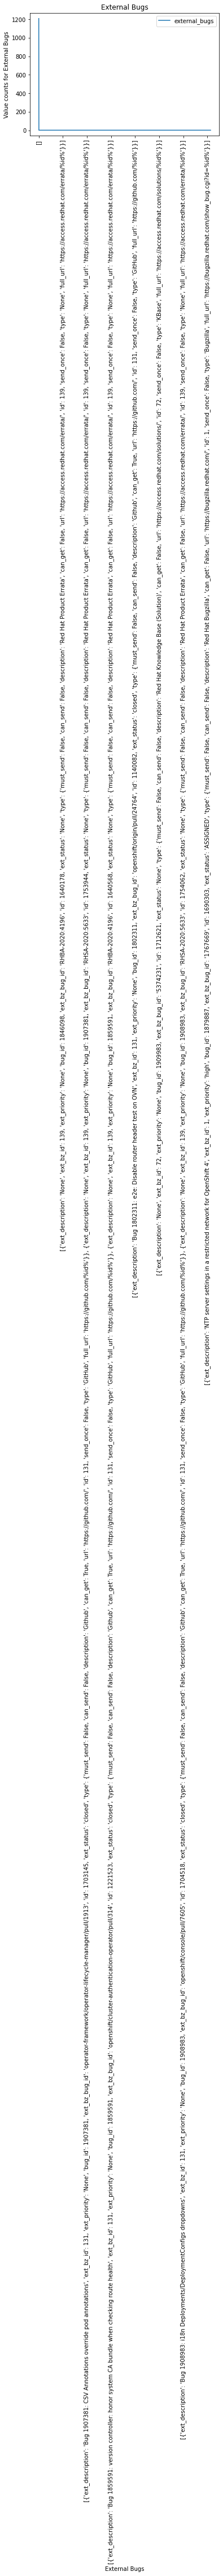

In [37]:
plt.figure(figsize=(16,5))
bugs_df.external_bugs.value_counts().to_frame().plot()
plt.xticks(rotation = 90)
plt.title("External Bugs")
plt.xlabel("External Bugs")
plt.ylabel("Value counts for External Bugs")
plt.show()

### summary

In [38]:
bugs_df.summary.head()

0    kube-apiserver-operator continuously generates...
1    CCO Leader Election Stalls on Deployment Rollouts
2    OCM Daemonset  always Rollout when set OCM-O t...
3    Nodes created while machine-config is upgradin...
4    External Storage [Driver: disk.csi.azure.com] ...
Name: summary, dtype: object

In [39]:
bugs_df.summary[0]

'kube-apiserver-operator continuously generates new revisions of kube-apiserver pod'

The bug `summary` is a short sentence which succinctly describes what the bug is about.

### is_open

In [40]:
bugs_df.is_open.head()

0    False
1    False
2    False
3    False
4    False
Name: is_open, dtype: object

The bug `is_open` field returns a boolean value indicating if the bug is currently open or not

### platform

In [41]:
bugs_df.platform.head()

0    Unspecified
1    Unspecified
2    Unspecified
3    Unspecified
4    Unspecified
Name: platform, dtype: object

`platform` field indicates the hardware platform the bug was observed on.

In [42]:
platforms = bugs_df.platform.unique()
print(platforms)

['Unspecified' 'x86_64' 'All' nan 's390x' 'ppc64le' 'ppc64']


In [43]:
platforms_count = []
for i in range(len(platforms)):
    platforms_count.append((bugs_df.platform == platforms[i]).sum())
platforms_count

[2226, 233, 121, 0, 34, 21, 1]

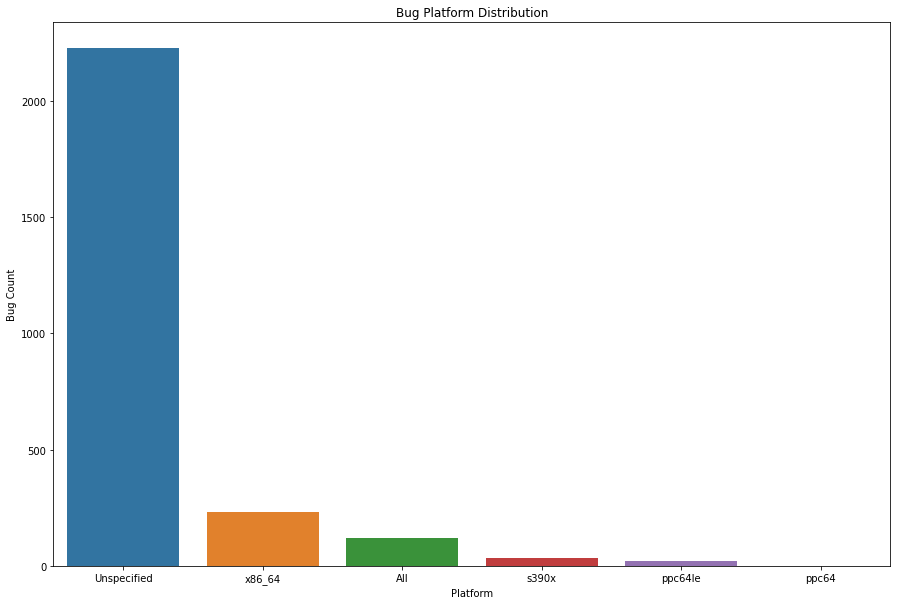

In [44]:
plt.figure(figsize = (15,10))
sns.barplot(platforms, platforms_count)
plt.xlabel("Platform")
plt.ylabel("Bug Count")
plt.title("Bug Platform Distribution")
plt.show()

### severity

In [45]:
bugs_df.severity.head()

0      high
1    medium
2       low
3    medium
4      high
Name: severity, dtype: object

The `severity` field categorzies the severity level of each bug. Let's see the different severity levels defined.

In [46]:
severity = bugs_df.severity.unique()
print(severity)

['high' 'medium' 'low' 'unspecified' 'urgent' nan]


In [47]:
severity_count = []
for i in range(len(severity)):
    severity_count.append((bugs_df.severity == severity[i]).sum())
severity_count

[911, 922, 311, 162, 330, 0]

Let's plot a simple graph to visualize the distribution of bug severities

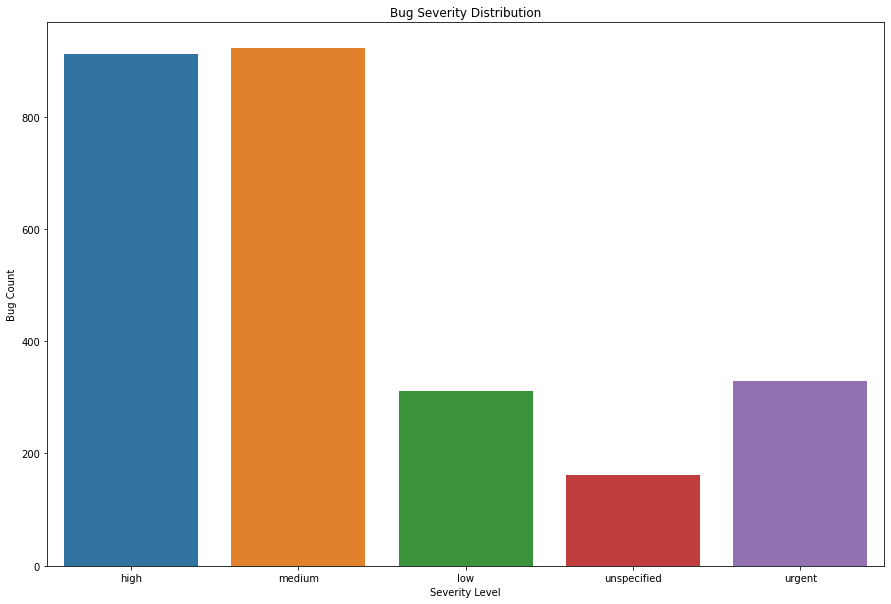

In [48]:
plt.figure(figsize = (15,10))
sns.barplot(severity, severity_count)
plt.xlabel("Severity Level")
plt.ylabel("Bug Count")
plt.title("Bug Severity Distribution")
plt.show()

### cf_environment

In [49]:
bugs_df.cf_environment.head()

0    
1    
2    
3    
4    
Name: cf_environment, dtype: object

In [50]:
cf_env = bugs_df.cf_environment.unique()
len(cf_env)

145

In [51]:
cf_env[1]

'Undiagnosed panic detected in pod'

Not too sure what `cf_environment` is supposed to return

### flags

In [52]:
bugs_df['flags'][:10]

0                                                   []
1                                                   []
2    [{'requestee': 'olemefer', 'status': '?', 'nam...
3    [{'requestee': 'nmalik', 'status': '?', 'name'...
4                                                   []
5                                                   []
6                                                   []
7    [{'requestee': 'jminter', 'status': '?', 'name...
8    [{'requestee': 'dgrigore', 'status': '?', 'nam...
9                                                   []
Name: flags, dtype: object

In [53]:
bugs_df['flags'][6]

[]

The `flags` field seems to return empty for most bugs. For thos bugs which have this field set, it seems to have redundant information which are already available in other bug fields so we can probably ignore this field.

### version

In [54]:
bugs_df.version.head()

0    4.4
1    4.6
2    4.4
3    4.4
4    4.8
Name: version, dtype: object

In [55]:
versions = bugs_df.version.unique()
versions

array(['4.4', '4.6', '4.8', '4.5', '4.3.z', '4.3.0', '4.7', '4.6.z', nan,
       '4.2.z', '4.2.0', '8.2', '1.3.0', 'unspecified', '2.5.0', '2.3.0',
       '2.4.0', 'rhacm-2.2.z', 'FDB 18.11', '2.4.1', 'RHEL 8.0',
       'FDP 20.E', 'rhacm-1.0.z', '16.1 (Train)'], dtype=object)

In [56]:
version_count = []
for i in range(len(versions)):
    version_count.append((bugs_df.version == versions[i]).sum())
version_count

[230,
 779,
 195,
 562,
 79,
 40,
 583,
 110,
 0,
 16,
 18,
 2,
 3,
 3,
 6,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

The `version` field indicates the version of the software the bug was found in. Let's plot a simple graph to visualize the distribution of bugs across different software versions.

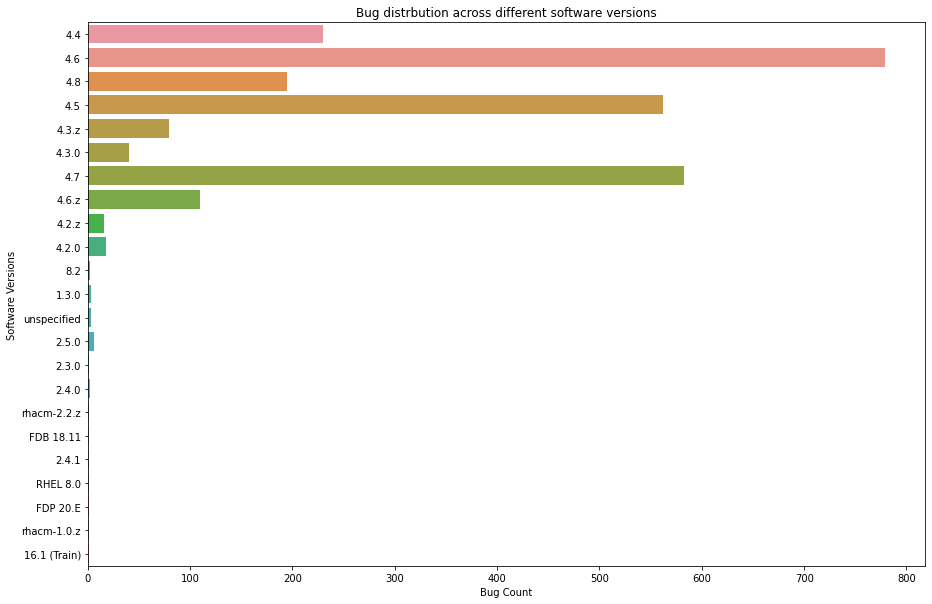

In [57]:
plt.figure(figsize = (15,10))
sns.barplot(version_count, versions)
plt.xlabel("Bug Count")
plt.ylabel("Software Versions")
plt.title("Bug distrbution across different software versions")
plt.show()

### tags

In [58]:
bugs_df.tags.head()

0    []
1    []
2    []
3    []
4    []
Name: tags, dtype: object

The `tags` field seems to be empty for most bugs so we can probably ignore this field.

### component

In [59]:
bugs_df.component.head()

0                  kube-apiserver
1       Cloud Credential Operator
2    openshift-controller-manager
3         Machine Config Operator
4                         Storage
Name: component, dtype: object

In [60]:
components = bugs_df.component.unique()
components

array(['kube-apiserver', 'Cloud Credential Operator',
       'openshift-controller-manager', 'Machine Config Operator',
       'Storage', 'Documentation', 'Cloud Compute',
       'Cluster Version Operator', 'Management Console', 'Etcd',
       'openshift-apiserver', 'Node', 'Installer', 'Jenkins', 'oc', 'OLM',
       'Networking', 'Logging', nan, 'Monitoring', 'RHCOS', 'Unknown',
       'Samples', 'DNS', 'Console Storage Plugin', 'Multi-Arch',
       'kube-scheduler', 'Console Kubevirt Plugin', 'Insights Operator',
       'Routing', 'Node Tuning Operator', 'Performance Addon Operator',
       'kernel-rt', 'apiserver-auth', 'Test Infrastructure',
       'Compliance Operator', 'Image Registry', 'Dev Console',
       'kube-controller-manager', 'assisted-installer',
       'Node Feature Discovery Operator', 'kube-storage-version-migrator',
       'Console Metal3 Plugin', 'Bare Metal Hardware Provisioning',
       'ISV Operators', 'config-operator', 'Special Resource Operator',
       'serv

In [61]:
component_count = []
for i in range(len(components)):
    component_count.append((bugs_df.component == components[i]).sum())

Bugs are categorised into Product and Component. Components are second-level categories and the `component` field indicates which component is affected by the bug.

### sub_component

In [62]:
bugs_df.sub_component.head()

0                      
1                      
2    controller-manager
3                      
4             Operators
Name: sub_component, dtype: object

In [63]:
sub_component = bugs_df.sub_component.unique()
len(sub_component)

49

In [64]:
sub_component

array(['', 'controller-manager', 'Operators', 'Other Providers',
       'Local Storage Operator', 'Autoscaler (HPA, VPA)',
       'OpenShift on RHV', 'OLM', 'ovn-kubernetes', 'SR-IOV', 'CRI-O',
       nan, 'openshift-sdn', 'multus', 'OpenStack CSI Drivers', 'Kubelet',
       'mDNS', 'Storage', 'openshift-installer', 'BareMetal Provider',
       'Kubernetes External Components', 'oVirt CSI Driver', 'Kubernetes',
       'Networking Misc', 'OpenShift on OpenStack', 'kuryr',
       'assisted-service', 'OperatorHub', 'Installer',
       'OpenStack Provider', 'openshift-ansible', 'ironic',
       'KubeVirt Provider', 'build', 'baremetal-operator', 'runtime-cfg',
       'cluster-baremetal-operator', 'stand-alone',
       'OpenShift on Bare Metal IPI', 'Single Node OpenShift', 'operator',
       'oVirt Provider', 'CPU manager', 'discovery-agent',
       'OpenShift on KubeVirt', 'assisted-ui', 'other', 'operand', 'apps'],
      dtype=object)

In [65]:
sub_component_count = []
for i in range(len(sub_component)):
    sub_component_count.append((bugs_df.sub_component == sub_component[i]).sum())
sub_component_count

[1645,
 3,
 58,
 38,
 13,
 12,
 19,
 117,
 142,
 17,
 43,
 0,
 136,
 20,
 14,
 86,
 4,
 17,
 39,
 6,
 7,
 8,
 24,
 1,
 17,
 38,
 20,
 18,
 3,
 6,
 5,
 6,
 2,
 1,
 2,
 4,
 7,
 2,
 13,
 2,
 3,
 5,
 2,
 1,
 1,
 4,
 1,
 2,
 2]

The `sub_component` field indicates the sub-component of a specifc component the bug affects.

### is_creator_accessible

In [66]:
bugs_df.is_creator_accessible.head()

0    True
1    True
2    True
3    True
4    True
Name: is_creator_accessible, dtype: object

The `is_creator_accessible` field returns a boolean value, but doesn't seem to be useful for our analysis. 

### cf_release_notes

In [67]:
bugs_df.cf_release_notes.tail()

2767    NaN
2768       
2769       
2770       
2771       
Name: cf_release_notes, dtype: object

The `cf_release_notes` is the basis of the errata or release note for the bug. It can also be used for change logs. However, it seems to be empty for most bugs and can be excluded from our analysis. 

### product

In [68]:
bugs_df['product'][:10]

0    OpenShift Container Platform
1    OpenShift Container Platform
2    OpenShift Container Platform
3    OpenShift Container Platform
4    OpenShift Container Platform
5    OpenShift Container Platform
6    OpenShift Container Platform
7    OpenShift Container Platform
8    OpenShift Container Platform
9    OpenShift Container Platform
Name: product, dtype: object

In [69]:
products = bugs_df['product'].unique()
products

array(['OpenShift Container Platform', nan, 'Red Hat Enterprise Linux 8',
       'Red Hat OpenShift Container Storage',
       'Migration Toolkit for Containers', 'Red Hat OpenShift Pipelines',
       'Container Native Virtualization (CNV)',
       'Red Hat Advanced Cluster Management for Kubernetes',
       'OpenShift Serverless', 'Red Hat Enterprise Linux Fast Datapath',
       'Red Hat OpenStack'], dtype=object)

The `product` field indicates the software product affected by the bug.

In [70]:
product_count = []
for i in range(len(products)):
    product_count.append((bugs_df['product'] == products[i]).sum())
product_count

[2610, 0, 2, 2, 3, 2, 10, 2, 1, 3, 1]

Let's plot a simple graph to visualize the distribution of bugs across different products

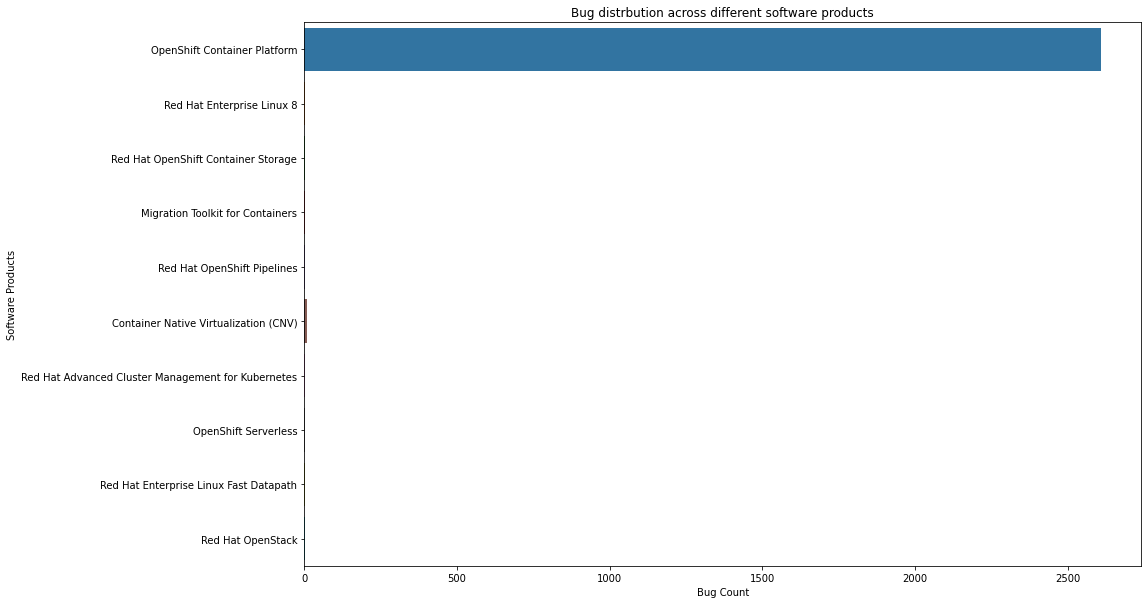

In [71]:
plt.figure(figsize = (15,10))
sns.barplot(product_count, products)
plt.xlabel("Bug Count")
plt.ylabel("Software Products")
plt.title("Bug distrbution across different software products")
plt.show()

### target_milestone

In [72]:
bugs_df.target_milestone.head()

0    ---
1    ---
2    ---
3    ---
4    ---
Name: target_milestone, dtype: object

In [73]:
bugs_df.target_milestone.unique()

array(['---', nan, 'rc'], dtype=object)

The `target_milestone` is used to define when the engineer the bug is assigned to expects to fix it. However, it doesn't seem to be applicable for most bugs.

### is_confirmed

In [74]:
bugs_df.is_confirmed.head()

0    True
1    True
2    True
3    True
4    True
Name: is_confirmed, dtype: object

The `is_confirmed` field seems to return a boolean value (not sure what it indicates) and doesn't seem to be useful for our analysis.

### components

In [75]:
bugs_df.components.head()

0                  [kube-apiserver]
1       [Cloud Credential Operator]
2    [openshift-controller-manager]
3         [Machine Config Operator]
4                         [Storage]
Name: components, dtype: object

The `components` field returns the same values as the `component` field, but in a list format.

### sub_components

In [76]:
bugs_df.sub_components.head()

0                                                   {}
1                                                   {}
2    {'openshift-controller-manager': ['controller-...
3                                                   {}
4                           {'Storage': ['Operators']}
Name: sub_components, dtype: object

The `sub_components` field is similar to the `sub_component` field, but returns both the component and sub-component affected by the bug in a dictionary format.

### versions

In [77]:
bugs_df.versions.head()

0    [4.4]
1    [4.6]
2    [4.4]
3    [4.4]
4    [4.8]
Name: versions, dtype: object

The `versions` field returns the same values as the `version` field, but in a list format.

### fixed_in

In [78]:
bugs_df.fixed_in[:15]

0     
1     
2     
3     
4     
5     
6     
7     
8     
9     
10    
11    
12    
13    
14    
Name: fixed_in, dtype: object

In [79]:
bugs_df.fixed_in.unique()

array(['', nan, 'OCP-Metal-v1.0.18.1',
       'runc-1.0.0-82.rhaos4.6.git086e841.el8', 'OCP-Metal-v1.0.12.1',
       '4.6.4', 'cri-o-1.20.2, openshift 4.7.4',
       'cri-o-1.19.0-62.rhaos4.6.git10c7a86.el8',
       'runc-1.0.0-81.rhaos4.6.git5b757d4',
       'podman-1.6.4-11.rhaos4.3.el8', '2.5.0',
       'milei@redhat.com , annair@redhat.com', 'OCP-Metal-v1.0.9.5',
       'virt-cdi-importer 2.6.0-15', 'OCP-Metal-V1.0.17.3',
       'OCP-Metal-v1.0.18.2', 'facet-lib v1.4.9',
       'assisted-ui-lib v0.0.13-wizard',
       '4.7.0-0.nightly-2020-12-17-001141',
       'annair@redhat.com, milei@redhat.com', 'v0.1.10',
       'runc-1.0.0-67.rc10.rhaos4.3.el7', 'jkaur@redhat.com', '4.8',
       'podman-1.9.3-1.rhaos4.6.el8'], dtype=object)

The `fixed_in` field seems to indicate the software version the bug was fixed in. However, it doesn't seem to be applicable to all bugs as some bugs may still be open and not yet resolved.

### weburl

In [80]:
bugs_df.weburl.head()

0    https://bugzilla.redhat.com/show_bug.cgi?id=19...
1    https://bugzilla.redhat.com/show_bug.cgi?id=18...
2    https://bugzilla.redhat.com/show_bug.cgi?id=18...
3    https://bugzilla.redhat.com/show_bug.cgi?id=18...
4    https://bugzilla.redhat.com/show_bug.cgi?id=19...
Name: weburl, dtype: object

In [81]:
bugs_df['bug_id'][0]

1934731

In [82]:
bugs_df['weburl'][0]

'https://bugzilla.redhat.com/show_bug.cgi?id=1934731'

The `weburl` field contains the bugzilla URL for the respective bug ID

## Merge Bug Details + Affected Jobs/Test DF

In [83]:
linked_and_associated_bugs.head()

,dashboard,job,test_name,bug_ids
0,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,"{'name': 'Overall', 'original-name': 'Overall'...",[]
1,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,[]
2,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'Operator results.operator conditions...,[]
3,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,[]
4,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,[]


In [84]:
firstdf = linked_and_associated_bugs.explode('bug_ids')
firstdf = firstdf.rename(columns={'bug_ids': 'bug_id'})
firstdf.head()

,dashboard,job,test_name,bug_id
0,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,"{'name': 'Overall', 'original-name': 'Overall'...",NaN
1,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,NaN
2,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'Operator results.operator conditions...,NaN
3,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,NaN
4,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,NaN


In [85]:
res = bugs_df.merge(
    firstdf,
#     how='left',
    left_on='bug_id',
    right_on='bug_id',
)
res.head()

,bug_id,autorefresh,priority,creator,blocks,assigned_to_detail,last_change_time,comments,is_cc_accessible,keywords,...,target_milestone,is_confirmed,components,versions,sub_component,fixed_in,weburl,dashboard,job,test_name
0,1928682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""redhat-openshift-ocp-release-4.2-informing""",release-openshift-ocp-installer-e2e-azure-seri...,"{'name': 'Pod', 'original-name': 'Pod', 'alert..."
1,1928682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""redhat-openshift-ocp-release-4.2-informing""",release-openshift-ocp-installer-e2e-gcp-serial...,"{'name': 'Pod', 'original-name': 'Pod', 'alert..."
2,1928682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""redhat-openshift-ocp-release-4.2-informing""",release-openshift-origin-installer-e2e-aws-upg...,"{'name': 'Pod', 'original-name': 'Pod', 'alert..."
3,1928682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""redhat-openshift-ocp-release-4.2-informing""",release-openshift-origin-installer-e2e-aws-upg...,"{'name': 'Pod', 'original-name': 'Pod', 'alert..."
4,1928682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""redhat-openshift-ocp-release-4.2-informing""",release-openshift-origin-installer-e2e-aws-upg...,"{'name': 'Pod', 'original-name': 'Pod', 'alert..."


## Get Linked Bug Data for All Dashboards

In [86]:
# # get all linked bugs
# associated_bugs = list()
# all_linked_bugs = set()
# for dashboard in tqdm(dashboard_names):
#     # get all jobs in this dashboard
#     response = requests.get(f"https://testgrid.k8s.io/{dashboard}/summary")
#     job_names = response.json().keys()
    
#     for job in job_names:
#         # get all tests in this job
#         response = requests.get(f"https://testgrid.k8s.io/{dashboard}/table?&show-stale-tests=&tab={job}")
        
#         # params to send to openshift ci search for tests under this job
#         args = {
#             'type': 'bug+junit',
#             'context': '-1',
#             'name': job,
#             'maxAge': max_age,
#             # DO NOT REMOVE THESE KEYS. THIS HACK PREVENTS REQUESTS FROM TIMING OUT.
#             # read more here - https://stackoverflow.com/a/63377265/9743348
#             'ajax': 'true',
#             'mobile': 'false',
#         }
        
#         for test in response.json().get('tests', []):
#             testname = test['name'].split('.', maxsplit=1)[-1]
            
#             # use test name as the search phrase
#             args['search'] = testname.replace('[', '\[').replace(']', '\]')

#             # search for linked and associated bugs for this test
#             response = requests.post(url, data=args)
#             soup = BeautifulSoup(response.content)

#             # the "em" objects in soup have information that can tell us
#             # whether or not this test had a linked bug for the given job name
#             em_objects = soup.find_all('em')
#             pct_affected = 0
#             for em in em_objects:
#                 if 'Found' in em.text:
#                     pct_affected = float(em.text.split()[2][:-1])
#                     break

#             # init to empty for this test result / reset to empty from previous test result
#             test_bugs = []
            
#             # if percent jobs affected is 0 then the linked bugs correspond to another job
#             if pct_affected > 0:
#                 result_rows = soup.find('table').find('tbody').find_all('tr')
#                 for row in result_rows:
#                     column_values = row.find_all('td')
                    
#                     # if there is only 1 column then the result is a junit, not bug
#                     if len(column_values) > 1:
#                         # check the second column to make sure it is a bug and not junit details result
#                         if column_values[1].text == 'bug':
#                             test_bugs.append(column_values[0].text[1:])
#                             all_linked_bugs.add(column_values[0].text[1:])

#             associated_bugs.append((dashboard, job, test, test_bugs))

## todo

combine it into a dataframe s.t. each row has one bugzilla id, and columns are status, component, etc + affected tests/jobs.